# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

Используем версию BigARTM 0.10.0

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit",
                                        target_folder="postnauka_batches")

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1 }, cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
dictionary = artm.Dictionary()
dictionary.gather(data_path="postnauka_batches")
model_artm.initialize(dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothBcg', 
                                                            tau=1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids={'text':1},
                                                            topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparseSbj', 
                                                            tau=-1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids={'text':1},
                                                            topic_names=["sbj"+str(i) for i in range(T-1)]))

Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# Ваш код
top_tokens_w = model_artm.score_tracker['top_words']
for topic_name in model_artm.topic_names:
    print('\n', topic_name, end=': ')
    for token in top_tokens_w.last_tokens[topic_name]:
        print(token, end=' ')


 sbj0: его власть александр писать историк имя великий римский знаменитый король церковь реформа средневековый над мысль 
 sbj1: там раз планета земля интересный находиться температура тело открывать маленький обнаруживать образовываться вокруг вода атмосфера 
 sbj2: система чтобы между создавать сложный общий направление простой движение ответ способность трудность переход сложно искусственный 
 sbj3: говорить сторона понятие связанный всегда отвечать лицо представление предмет отличаться концепция опыт меняться восприятие рассматривать 
 sbj4: должный вид появляться каждый вещь любой иной качество мой нельзя особый этап оценка никто очередь 
 sbj5: можно при получать структура материал использовать сделать достаточно свойство элемент огромный пора применение устройство сей 
 sbj6: книга научный написать выходить тема автор фильм массовый абсолютно документ герой брать обращать молодой театр 
 sbj7: сам социальный кто после общество принимать считать степень род социология собственно

In [13]:
top_tokens_auth = model_artm.score_tracker['top_authors']
for topic_name in model_artm.topic_names:
    print('\n', topic_name, end=': ')
    for token in top_tokens_auth.last_tokens[topic_name]:
        print(token, end=' ')


 sbj0: Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Ольга_Вайнштейн Михаил_Бойцов Алексей_Юдин Игорь_Данилевский Раиса_Кирсанова Владимир_Кантор Елена_Браун Игорь_Курукин Елена_Уханова Екатерина_Болтунова Арчил_Балахванцев 
 sbj1: Елизавета_Бонч-Осмоловская Кирилл_Еськов Сергей_Попов Дмитрий_Титов Николай_Пименов Татьяна_Смоктунович Андрей_Иванцов Зоригто_Намсараев Светлана_Дедыш Александр_Марков Сергей_Наугольных Юлия_Краус Александр_Слободкин Елизавета_Ривкина Наталья_Новикова 
 sbj2: Михаил_Пантелеев Александр_Поддьяков Дмитрий_Громов Владимир_Мележик Варвара_Веденина Антон_Суворов Даниэль_Сельва Михаил_Фейгельман Виталий_Пальчиков Алексей_Котов Кирилл_Зыбин Кристофер_Уиншип Андрей_Шевельков Александра_Скрипченко Андрей_Чабовский 
 sbj3: Виталий_Куренной Сергей_Арутюнов Владимир_Миронов Максим_Кронгауз Алексей_Руткевич Николай_Плотников Павел_Степанцов Дмитрий_Куракин Дмитрий_Иванов Фёдор_Гиренок Татьяна_Котова Михаил_Маяцкий Ирина_Каспэ Андрей_Коротаев Григори

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = [ # запишите названия тем в список
    'История', #0
    'Геология', #1
    'Система?', #2
    'Философия', #3
    'Вид?', #4
    'Материаловедение', #5
    'Театроведение', #6
    'Социология', #7
    'Наука', #8
    'Физика элементарных частиц', #9
    'История России', #10
    'Психология', #11
    'Нейрофизиология', #12
    'История древнего мира', #13
    'Астрономия', #14
    'Когнитивные науки/ИТ', #15
    'Группа', #16
    'СССР/Германия', #17
    'Лингвистика', #18
    'Общество', #19
    'Урбанистика', #20
    'Медицина', #21
    'Медиа', #22
    'Математика', #23
    'Мифология', #24
    'Филология', #25
    'Экономика', #26
    'Генетика', #27
    'Образование' #28
]
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids='author')

In [16]:
theta.shape

(30, 1728)

In [17]:
phi_a.shape

(539, 30)

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

In [18]:
theta.iloc[:, :100]

http://postnauka.ru/video/10006  http://postnauka.ru/video/10379  \
sbj0                          0.037776                     0.000000e+00   
sbj1                          0.000000                     0.000000e+00   
sbj2                          0.038195                     4.302627e-02   
sbj3                          0.000000                     4.315818e-02   
sbj4                          0.076739                     0.000000e+00   
sbj5                          0.000000                     2.156706e-01   
sbj6                          0.000000                     0.000000e+00   
sbj7                          0.000000                     0.000000e+00   
sbj8                          0.189764                     1.713010e-01   
sbj9                          0.000000                     2.185043e-14   
sbj10                         0.000000                     0.000000e+00   
sbj11                         0.000000                     0.000000e+00   
sbj12                         0.000000                     0.000000e+00   
sbj13                         0.037509                     0.000000e+00   
sbj14                         0.000000                     0.000000e+00   
sbj15                         0.000000                     8.595202e-02   
sbj16                         0.000000                     4.212043e-15   
sbj17                         0.000000                     0.000000e+00   
sbj18                         0.037991                     0.000000e+00   
sbj19                         0.000000                     0.000000e+00   
sbj20                         0.000000                     2.397335e-12   
sbj21                         0.076368                     0.000000e+00   
sbj22                         0.000000                     0.000000e+00   
sbj23                         0.076501                     0.000000e+00   
sbj24                         0.037674                     4.246249e-02   
sbj25                         0.000000                     4.295762e-02   
sbj26                         0.000000                     0.000000e+00   
sbj27                         0.152888                     4.313565e-02   
sbj28                         0.037817                     4.285615e-02   
bcg                           0.200778                     2.694800e-01   

       http://postnauka.ru/video/10380  http://postnauka.ru/video/10381  \
sbj0                          0.022491                     1.803012e-01   
sbj1                          0.045704                     0.000000e+00   
sbj2                          0.000000                     6.017182e-02   
sbj3                          0.022989                     5.994915e-02   
sbj4                          0.023089                     0.000000e+00   
sbj5                          0.045569                     0.000000e+00   
sbj6                          0.000000                     0.000000e+00   
sbj7                          0.000000                     3.011396e-02   
sbj8                          0.137459                     1.195457e-01   
sbj9                          0.000000                     0.000000e+00   
sbj10                         0.022924                     6.003047e-02   
sbj11                         0.000000                     4.287592e-14   
sbj12                         0.000000                     0.000000e+00   
sbj13                         0.023038                     4.780606e-02   
sbj14                         0.022759                     0.000000e+00   
sbj15                         0.000000                     0.000000e+00   
sbj16                         0.000000                     1.182110e-02   
sbj17                         0.091644                     2.995342e-02   
sbj18                         0.000000                     0.000000e+00   
sbj19                         0.023031                     4.515687e-10   
sbj20                         0.000000                     3.006030e-02   
sbj21                         0

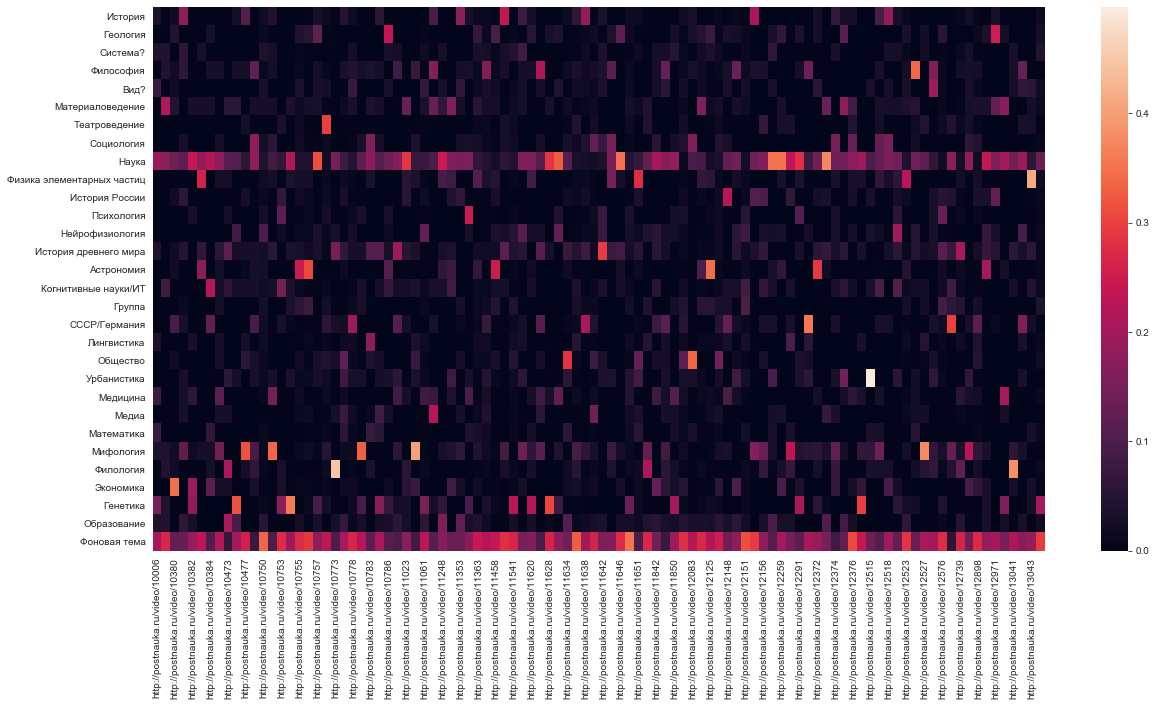

In [19]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.iloc[:,:100], yticklabels=topic_labels)
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [20]:
# Ваш код
p_t = pd.DataFrame(np.zeros((T, 1)), index=topic_labels)
for i in range(T):
    p_t.iloc[i] = sum(theta.iloc[i])/1728

In [21]:
p_t.sum()

0    1.0
dtype: float64

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [22]:
p_t.sort_values(0)

0
Математика                  0.013060
Медиа                       0.014102
Театроведение               0.014117
Психология                  0.017138
Урбанистика                 0.017743
Система?                    0.018409
Вид?                        0.019409
Философия                   0.020291
Филология                   0.020515
Медицина                    0.021490
Нейрофизиология             0.022013
Общество                    0.022032
Лингвистика                 0.022125
Социология                  0.023263
История России              0.024177
Когнитивные науки/ИТ        0.024493
Экономика                   0.024497
История                     0.027531
Материаловедение            0.028498
Геология                    0.028677
Образование                 0.028928
Генетика                    0.030221
Астрономия                  0.032804
Группа                      0.034354
СССР/Германия               0.034381
История древнего мира       0.036293
Мифология                   0.036492
Физика элементарных частиц  0.036891
Наука                       0.055328
Фоновая тема                0.250729

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

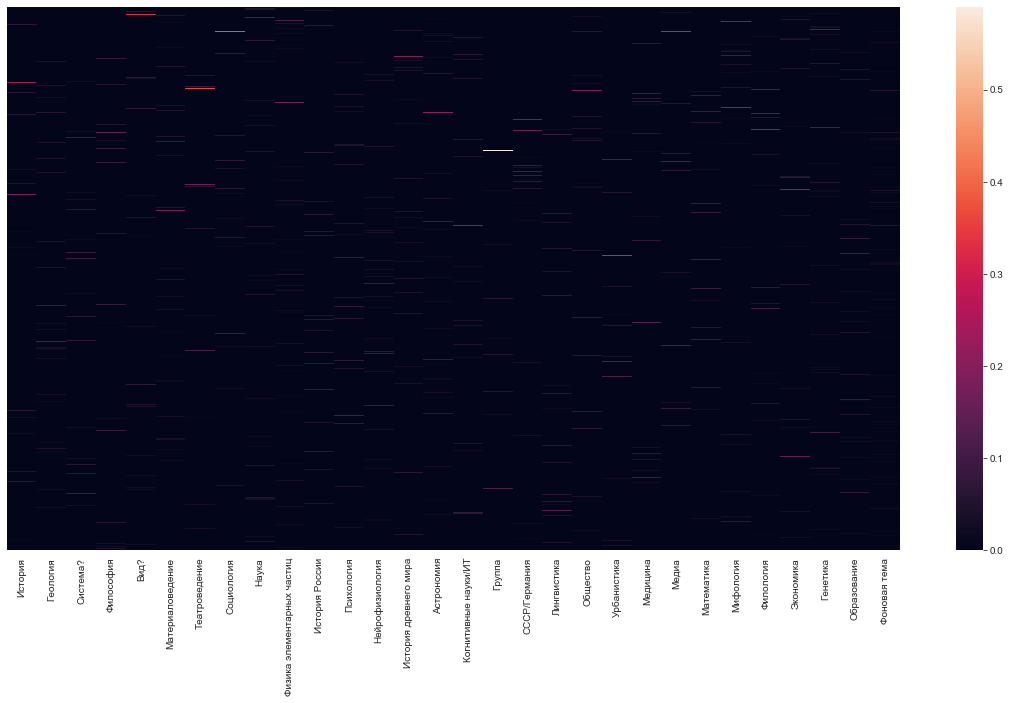

In [23]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False, xticklabels=topic_labels)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [24]:
phi_a

sbj0          sbj1          sbj2  \
(author, Ярослав_Исполатов)        0.0  0.000000e+00  2.616760e-09   
(author, Сергей_Демокритов)        0.0  0.000000e+00  2.020986e-16   
(author, Руслан_Смелянский)        0.0  0.000000e+00  0.000000e+00   
(author, Александр_Апт)            0.0  0.000000e+00  0.000000e+00   
(author, Людмила_Новикова)         0.0  0.000000e+00  0.000000e+00   
...                                ...           ...           ...   
(author, Дарья_Радченко)           0.0  0.000000e+00  0.000000e+00   
(author, Ирина_Каспэ)              0.0  0.000000e+00  0.000000e+00   
(author, Марина_Корсакова-Крейн)   0.0  0.000000e+00  0.000000e+00   
(author, Павел_Степанцов)          0.0  0.000000e+00  0.000000e+00   
(author, Дэвид_Гросс)              0.0  4.827714e-14  0.000000e+00   

                                          sbj3      sbj4  sbj5  sbj6  \
(author, Ярослав_Исполатов)       2.646506e-11  0.000001   0.0   0.0   
(author, Сергей_Демокритов)       0.000000e+00  0.000000   0.0   0.0   
(author, Руслан_Смелянский)       0.000000e+00  0.000000   0.0   0.0   
(author, Александр_Апт)           0.000000e+00  0.000000   0.0   0.0   
(author, Людмила_Новикова)        0.000000e+00  0.000000   0.0   0.0   
...                                        ...       ...   ...   ...   
(author, Дарья_Радченко)          0.000000e+00  0.000000   0.0   0.0   
(author, Ирина_Каспэ)             2.950661e-02  0.000000   0.0   0.0   
(author, Марина_Корсакова-Крейн)  0.000000e+00  0.000000   0.0   0.0   
(author, Павел_Степанцов)         5.901302e-02  0.000000   0.0   0.0   
(author, Дэвид_Гросс)             0.000000e+00  0.000000   0.0   0.0   

                                          sbj7          sbj8      sbj9  ...  \
(author, Ярослав_Исполатов)       0.000000e+00  1.416914e-10  0.000000  ...   
(author, Сергей_Демокритов)       0.000000e+00  0.000000e+00  0.030967  ...   
(author, Руслан_Смелянский)       0.000000e+00  5.323895e-02  0.000000  ...   
(author, Александр_Апт)           0.000000e+00  5.323835e-02  0.000000  ...   
(author, Людмила_Новикова)        2.314742e-16  0.000000e+00  0.000000  ...   
...                                        ...           ...       ...  ...   
(author, Дарья_Радченко)          0.000000e+00  0.000000e+00  0.000000  ...   
(author, Ирина_Каспэ)             0.000000e+00  0.000000e+00  0.000000  ...   
(author, Марина_Корсакова-Крейн)  0.000000e+00  0.000000e+00  0.020645  ...   
(author, Павел_Степанцов)         0.000000e+00  2.643103e-13  0.000000  ...   
(author, Дэвид_Гросс)             0.000000e+00  0.000000e+00  0.010321  ...   

                                         sbj20         sbj21         sbj22  \
(author, Ярослав_Исполатов)       0.000000e+00  1.054339e-07  2.840773e-13   
(author, Сергей_Демокритов)       0.000000e+00  0.000000e+00  0.000000e+00   
(author, Руслан_Смелянский)       5.551155e-08  0.000000e+00  0.000000e+00   
(author, Александр_Апт)           0.000000e+00  0.000000e+00  0.000000e+00   
(author, Людмила_Новикова)        0.000000e+00  0.000000e+00  0.000000e+00   
...                                        ...           ...           ...   
(author, Дарья_Радченко)          3.857317e-02  0.000000e+00  0.000000e+00   
(author, Ирина_Каспэ)             0.000000e+00  0.000000e+00  0.000000e+00   
(author, Марина_Корсакова-Крейн)  0.000000e+00  0.000000e+00  0.000000e+00   
(author, Павел_Степанцов)         6.134563e-10  0.000000e+00  0.000000e+00   
(author, Дэвид_Гросс)             0.000000e+00  0.000000e+00  0.000000e+00   

                                         sbj23         sbj24  sbj25  \
(author, Ярослав_Исполатов)       0.000000e+00  0.000000e+00    0.0   
(author, Сергей_Демокритов)       0.000000e+00  0.000000e+00    0.0   
(author, Руслан_Смелянский)       0.000000e+00  0.000000e+00    0.0   
(author, Александр_Апт)           0.000000e+00  0.000000e+00    0.0   
(author, Людмила_Новикова)        0.000000e+00  4.405699e-08    0.0   
...             

In [25]:
phi_a[phi_a > 0.01].count(axis=1).sort_values(ascending=False).head(20)

(author, Виктор_Вахштайн)          4
(author, Михаил_Маяцкий)           3
(author, Владимир_Муронец)         3
(author, Михаил_Гельфанд)          3
(author, Елена_Брызгалина)         3
(author, Михаил_Киселев)           3
(author, Виталий_Куренной)         3
(author, Михаил_Соколов)           2
(author, Ирина_Савельева)          2
(author, Владимир_Плунгян)         2
(author, Константин_Мирошников)    2
(author, Петр_Дружинин)            2
(author, Андрей_Чабовский)         2
(author, Алексей_Бартошевич)       2
(author, Мария_Фаликман)           2
(author, Владимир_Пудалов)         2
(author, Александр_Марков)         2
(author, Андрей_Журавлев)          2
(author, Раиса_Кирсанова)          2
(author, Константин_Анохин)        2
dtype: int64

In [26]:
phi_a[phi_a > 0.01].count(axis=1).groupby(phi_a[phi_a > 0.01].count(axis=1)).count()

0     21
1    459
2     52
3      6
4      1
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [27]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [42]:
# Ваш код
phi_a.columns = p_t.index
numerator = phi_a.mul(p_t.iloc[:, 0], axis=1)
p_ta = numerator.div(numerator.sum(axis=1), axis=0)

In [43]:
p_ta

История      Геология      Система?  \
(author, Ярослав_Исполатов)           0.0  0.000000e+00  3.316069e-08   
(author, Сергей_Демокритов)           0.0  0.000000e+00  3.256558e-15   
(author, Руслан_Смелянский)           0.0  0.000000e+00  0.000000e+00   
(author, Александр_Апт)               0.0  0.000000e+00  0.000000e+00   
(author, Людмила_Новикова)            0.0  0.000000e+00  0.000000e+00   
...                                   ...           ...           ...   
(author, Дарья_Радченко)              0.0  0.000000e+00  0.000000e+00   
(author, Ирина_Каспэ)                 0.0  0.000000e+00  0.000000e+00   
(author, Марина_Корсакова-Крейн)      0.0  0.000000e+00  0.000000e+00   
(author, Павел_Степанцов)             0.0  0.000000e+00  0.000000e+00   
(author, Дэвид_Гросс)                 0.0  3.634471e-12  0.000000e+00   

                                     Философия      Вид?  Материаловедение  \
(author, Ярослав_Исполатов)       3.696643e-10  0.000017               0.0   
(author, Сергей_Демокритов)       0.000000e+00  0.000000               0.0   
(author, Руслан_Смелянский)       0.000000e+00  0.000000               0.0   
(author, Александр_Апт)           0.000000e+00  0.000000               0.0   
(author, Людмила_Новикова)        0.000000e+00  0.000000               0.0   
...                                        ...       ...               ...   
(author, Дарья_Радченко)          0.000000e+00  0.000000               0.0   
(author, Ирина_Каспэ)             1.000000e+00  0.000000               0.0   
(author, Марина_Корсакова-Крейн)  0.000000e+00  0.000000               0.0   
(author, Павел_Степанцов)         9.999968e-01  0.000000               0.0   
(author, Дэвид_Гросс)             0.000000e+00  0.000000               0.0   

                                  Театроведение    Социология         Наука  \
(author, Ярослав_Исполатов)                 0.0  0.000000e+00  5.396697e-09   
(author, Сергей_Демокритов)                 0.0  0.000000e+00  0.000000e+00   
(author, Руслан_Смелянский)                 0.0  0.000000e+00  9.999997e-01   
(author, Александр_Апт)                     0.0  0.000000e+00  9.999964e-01   
(author, Людмила_Новикова)                  0.0  5.162960e-15  0.000000e+00   
...                                         ...           ...           ...   
(author, Дарья_Радченко)                    0.0  0.000000e+00  0.000000e+00   
(author, Ирина_Каспэ)                       0.0  0.000000e+00  0.000000e+00   
(author, Марина_Корсакова-Крейн)            0.0  0.000000e+00  0.000000e+00   
(author, Павел_Степанцов)                   0.0  0.000000e+00  1.221278e-11   
(author, Дэвид_Гросс)                       0.0  0.000000e+00  0.000000e+00   

                                  Физика элементарных частиц  ...  \
(author, Ярослав_Исполатов)                         0.000000  ...   
(author, Сергей_Демокритов)                         1.000000  ...   
(author, Руслан_Смелянский)                         0.000000  ...   
(author, Александр_Апт)                             0.000000  ...   
(author, Людмила_Новикова)                          0.000000  ...   
...                                                      ...  ...   
(author, Дарья_Радченко)                            0.000000  ...   
(author, Ирина_Каспэ)                               0.000000  ...   
(author, Марина_Корсакова-Крейн)                    1.000000  ...   
(author, Павел_Степанцов)                           0.000000  ...   
(author, Дэвид_Гросс)                               0.999584  ...   

                                   Урбанистика  Медицина         Медиа  \
(author, Ярослав_Исполатов)       0.000000e+00  0.000002  2.757801e-12   
(author, Сергей_Демокритов)       0.000000e+00  0.000000  0.000000e+00   
(author, Руслан_Смелянский)       3.343721e-07  0.000000  0.000000e+00   
(author, Александр_Апт)           0.000000e+00  0.000000  0.000000e+00   
(author, Людмила_Новикова)        0.000000e+00  0.000000  0.000000e+00  

In [44]:
p_ta.iloc[0].sum()

1.0

In [45]:
mds_cos = MDS(dissimilarity='precomputed')
cos_matrix = pairwise_distances(p_ta, metric='cosine')
MDS_transformed_cos = mds_cos.fit_transform(cos_matrix)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [46]:
MDS_transformed_cos

array([[ 0.18218999,  0.52473678],
       [-0.41537148,  0.58957453],
       [ 0.56345254, -0.46182781],
       ...,
       [-0.41537148,  0.58957453],
       [-0.72807726,  0.09139642],
       [-0.41520509,  0.58957381]])

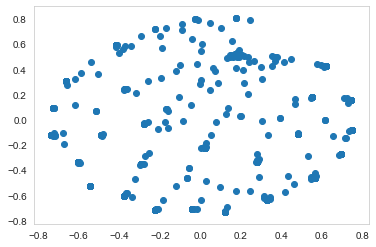

In [47]:
# Ваш код
plt.scatter(MDS_transformed_cos[:, 0], 
            MDS_transformed_cos[:, 1])
plt.show()

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

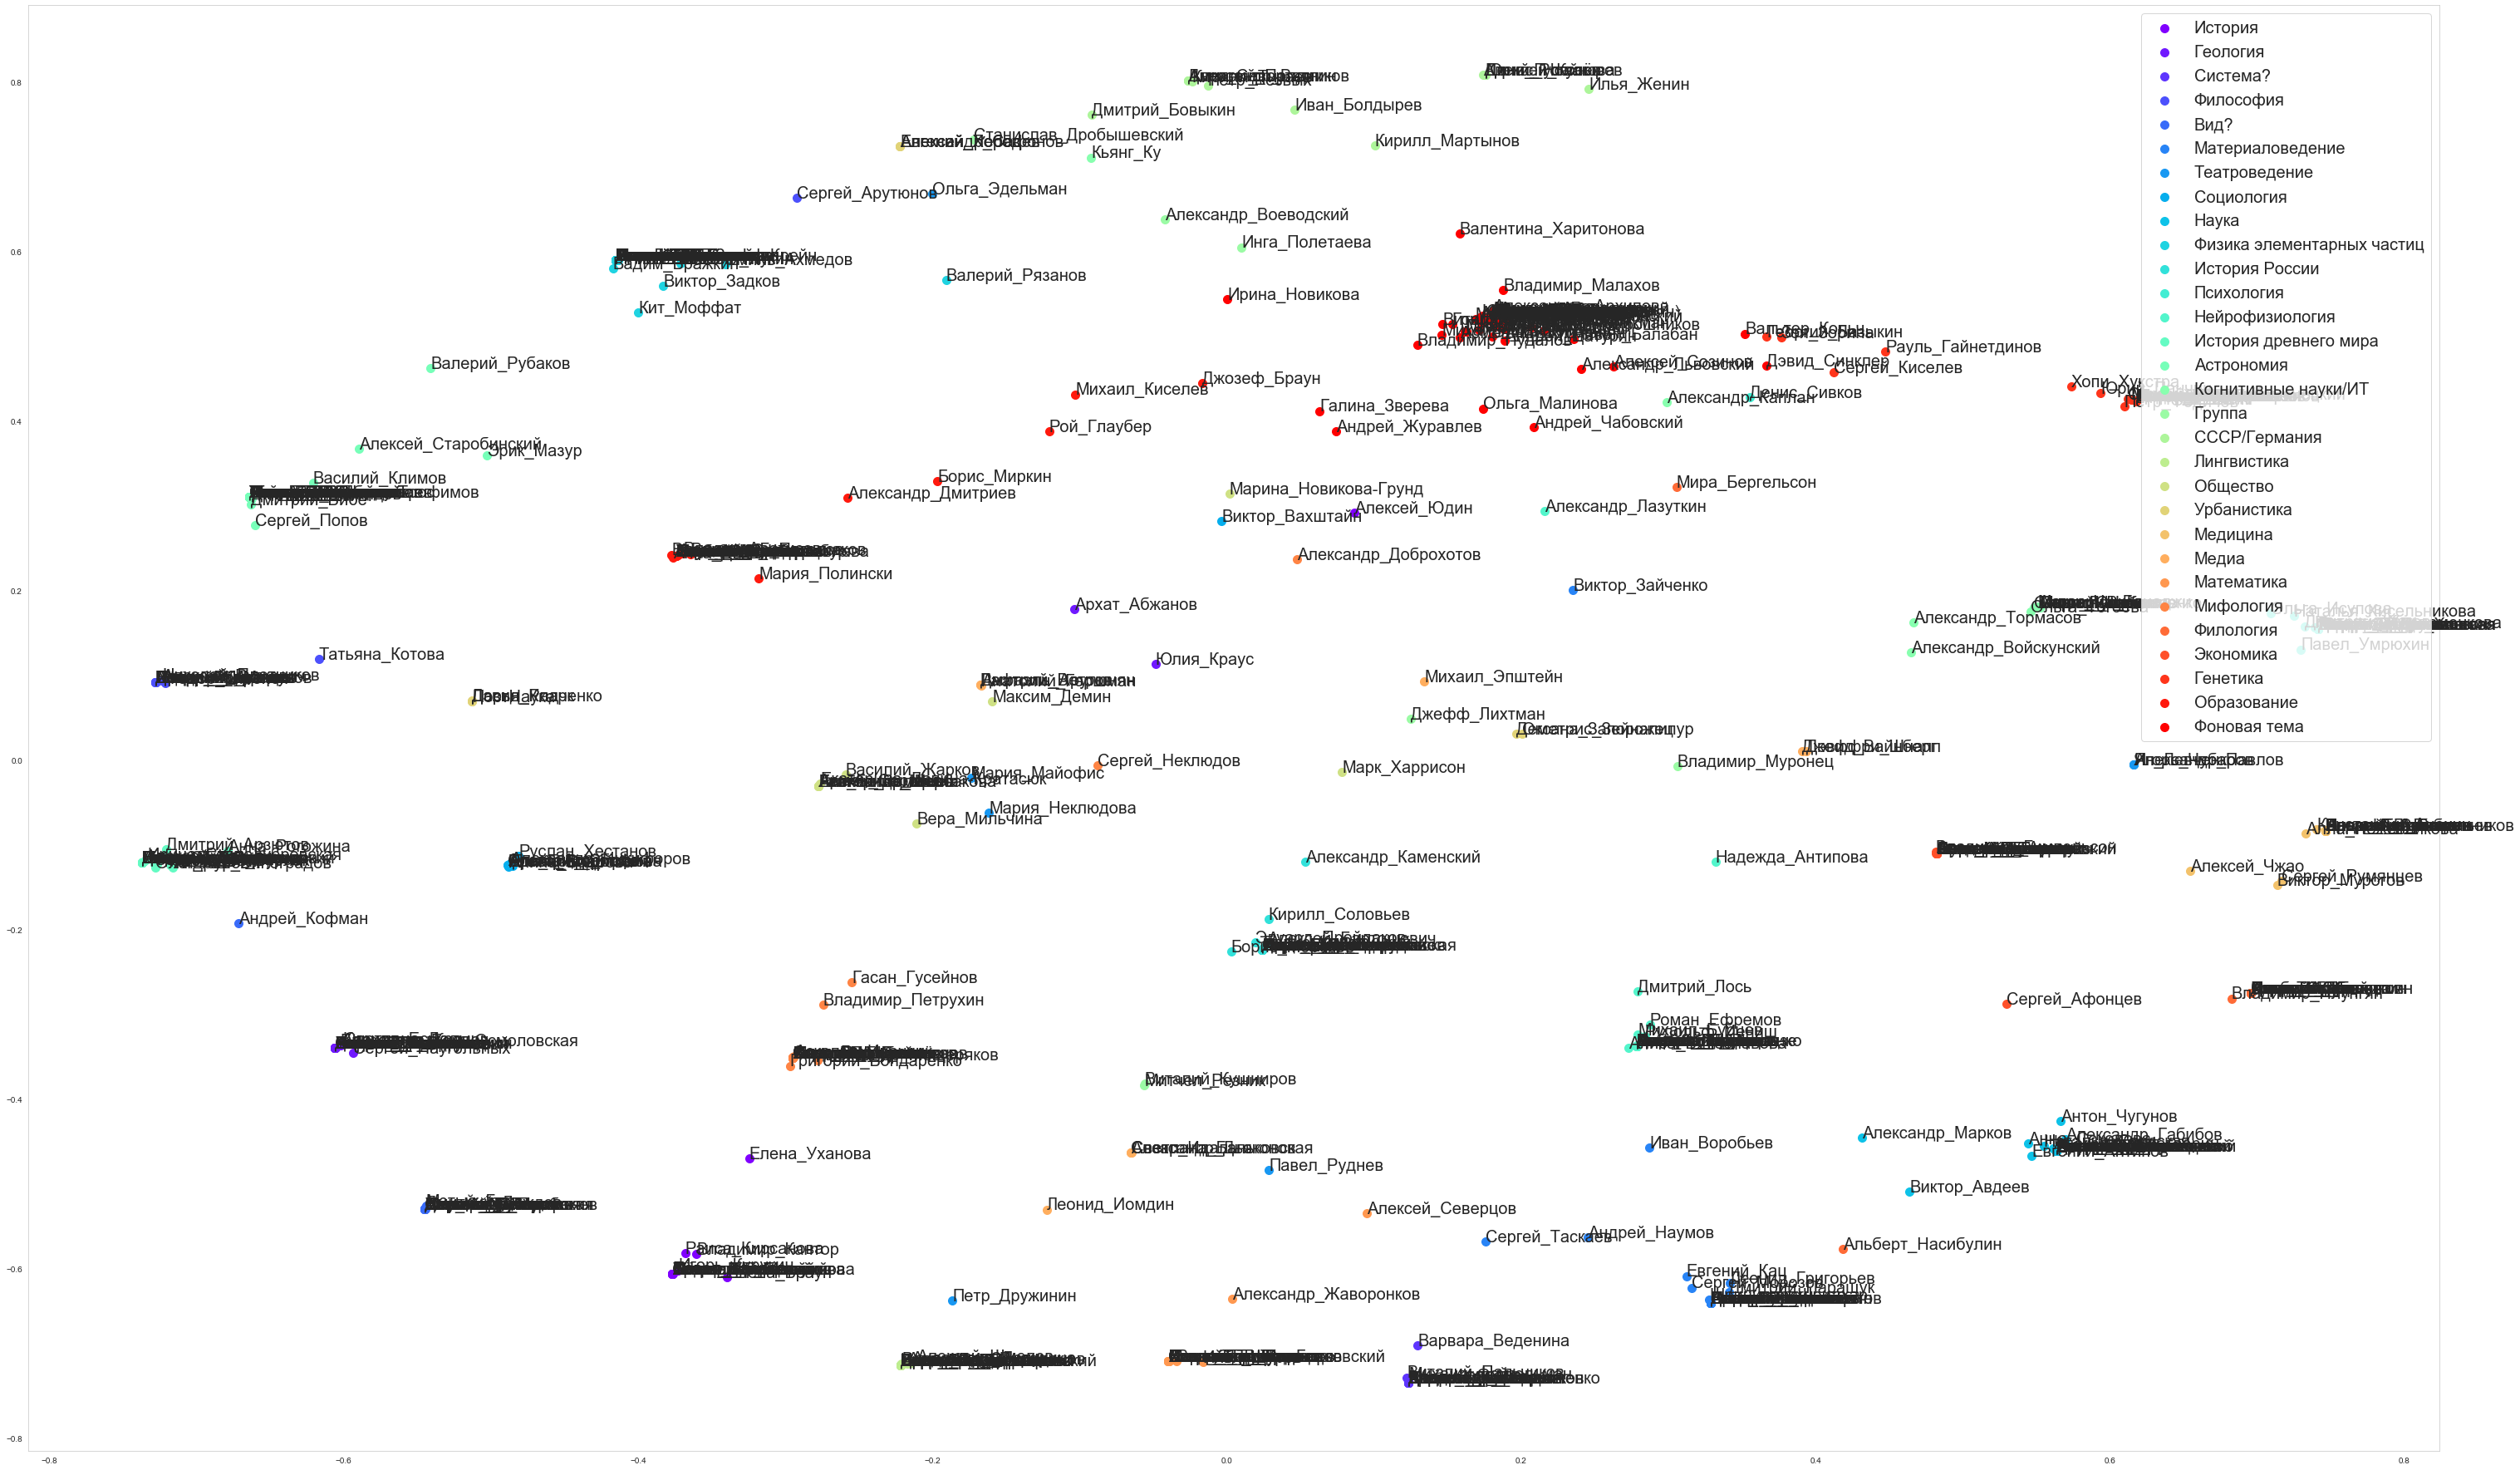

In [52]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
# dataframe индексов колонок с максимальными вероятностями для каждого автора
max_topics = pd.DataFrame(map(lambda x: p_ta.columns.get_loc(x), p_ta.idxmax(axis=1).values))

plt.figure(figsize=(52, 32))
for topic, color in zip(range(30), colors):
    authors = max_topics.index[max_topics[0]==topic]
    plt.scatter(MDS_transformed_cos[authors, 0],
                MDS_transformed_cos[authors, 1], 
                c=np.array([color]),
                s=100,
                label=topic_labels[topic]
           )
plt.legend(prop={'size': 20})
for author, xy in zip(p_ta.index, MDS_transformed_cos):
    plt.annotate(s=author[1], xy=xy, fontsize=20)
plt.savefig('map.pdf')
plt.show()

Wall time: 12min 43s


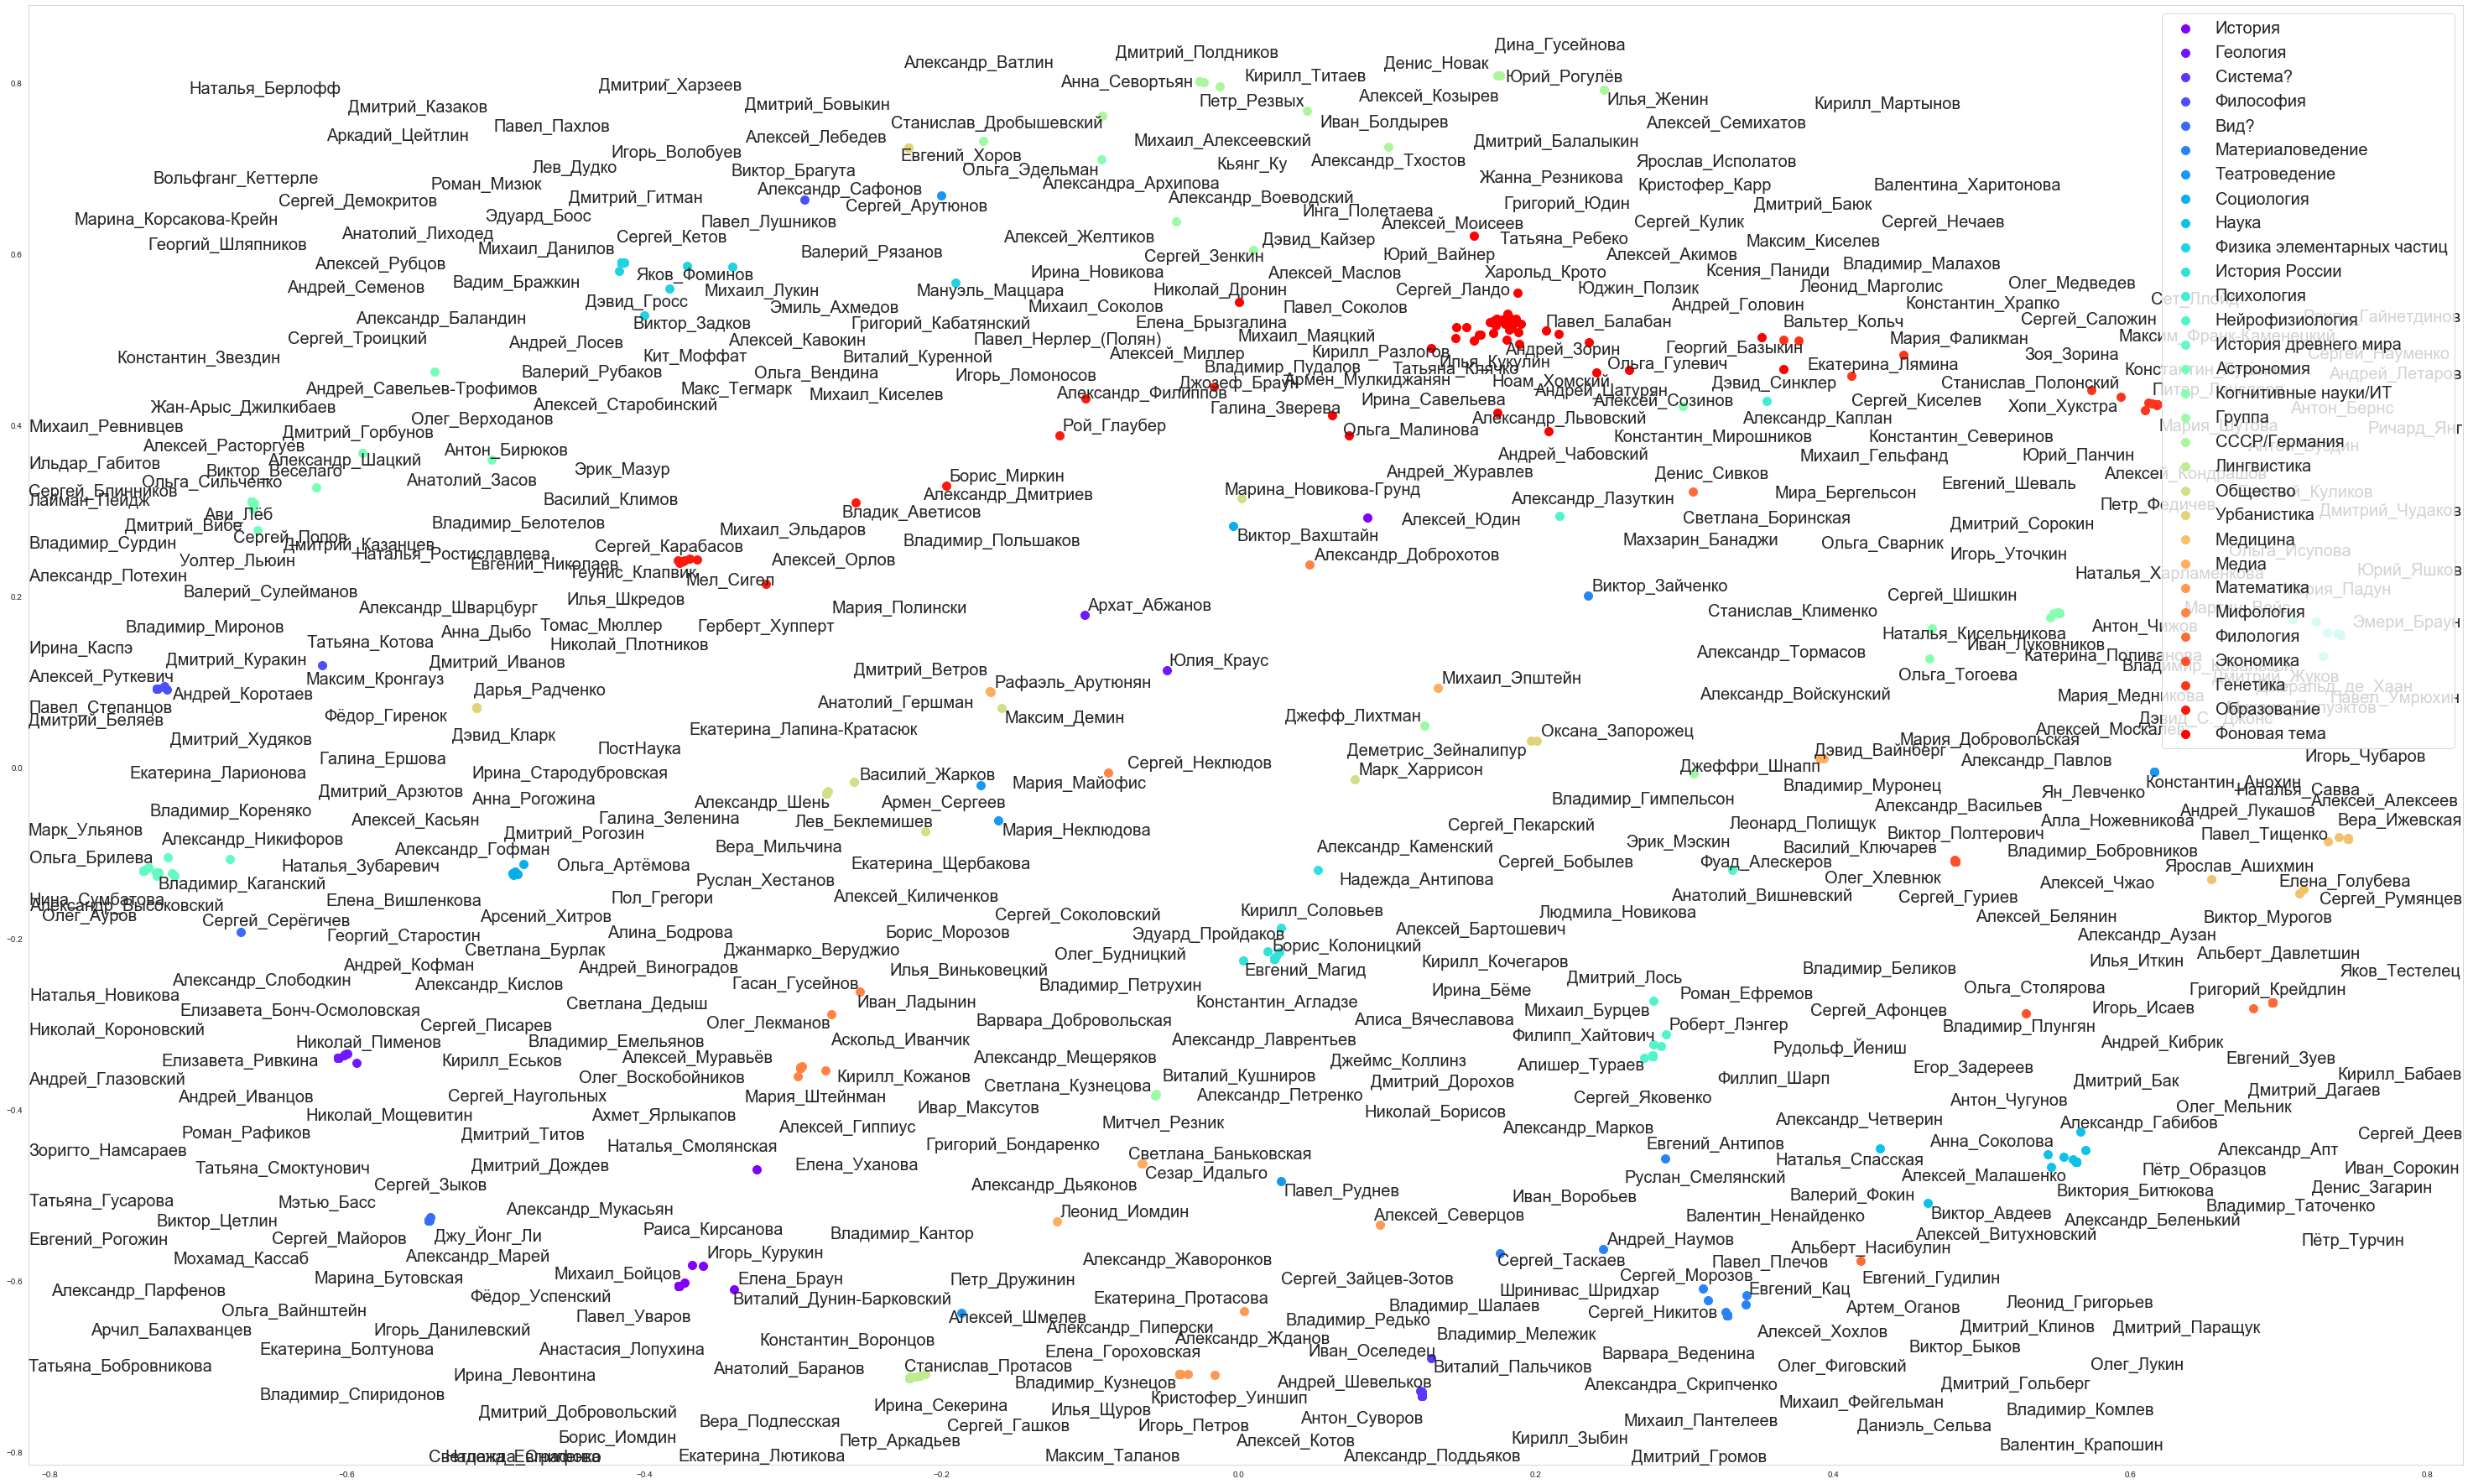

In [50]:
from adjustText import adjust_text # сторонняя библиотека
plt.figure(figsize=(52, 32))
for topic, color in zip(range(30), colors):
    authors = max_topics.index[max_topics[0]==topic]
    plt.scatter(MDS_transformed_cos[authors, 0],
                MDS_transformed_cos[authors, 1], 
                c=np.array([color]),
                s=100,
                label=topic_labels[topic]
           )
plt.legend(prop={'size': 20})
# for author, xy in zip(p_ta.index, MDS_transformed_cos):
#     plt.annotate(s=author[1], xy=xy, fontsize=20)
texts = [
    plt.text(xy[0], xy[1], author[1], ha='center', va='center', fontsize=20) 
    for author, xy in zip(p_ta.index, MDS_transformed_cos)
]
%time adjust_text(texts)
plt.show()

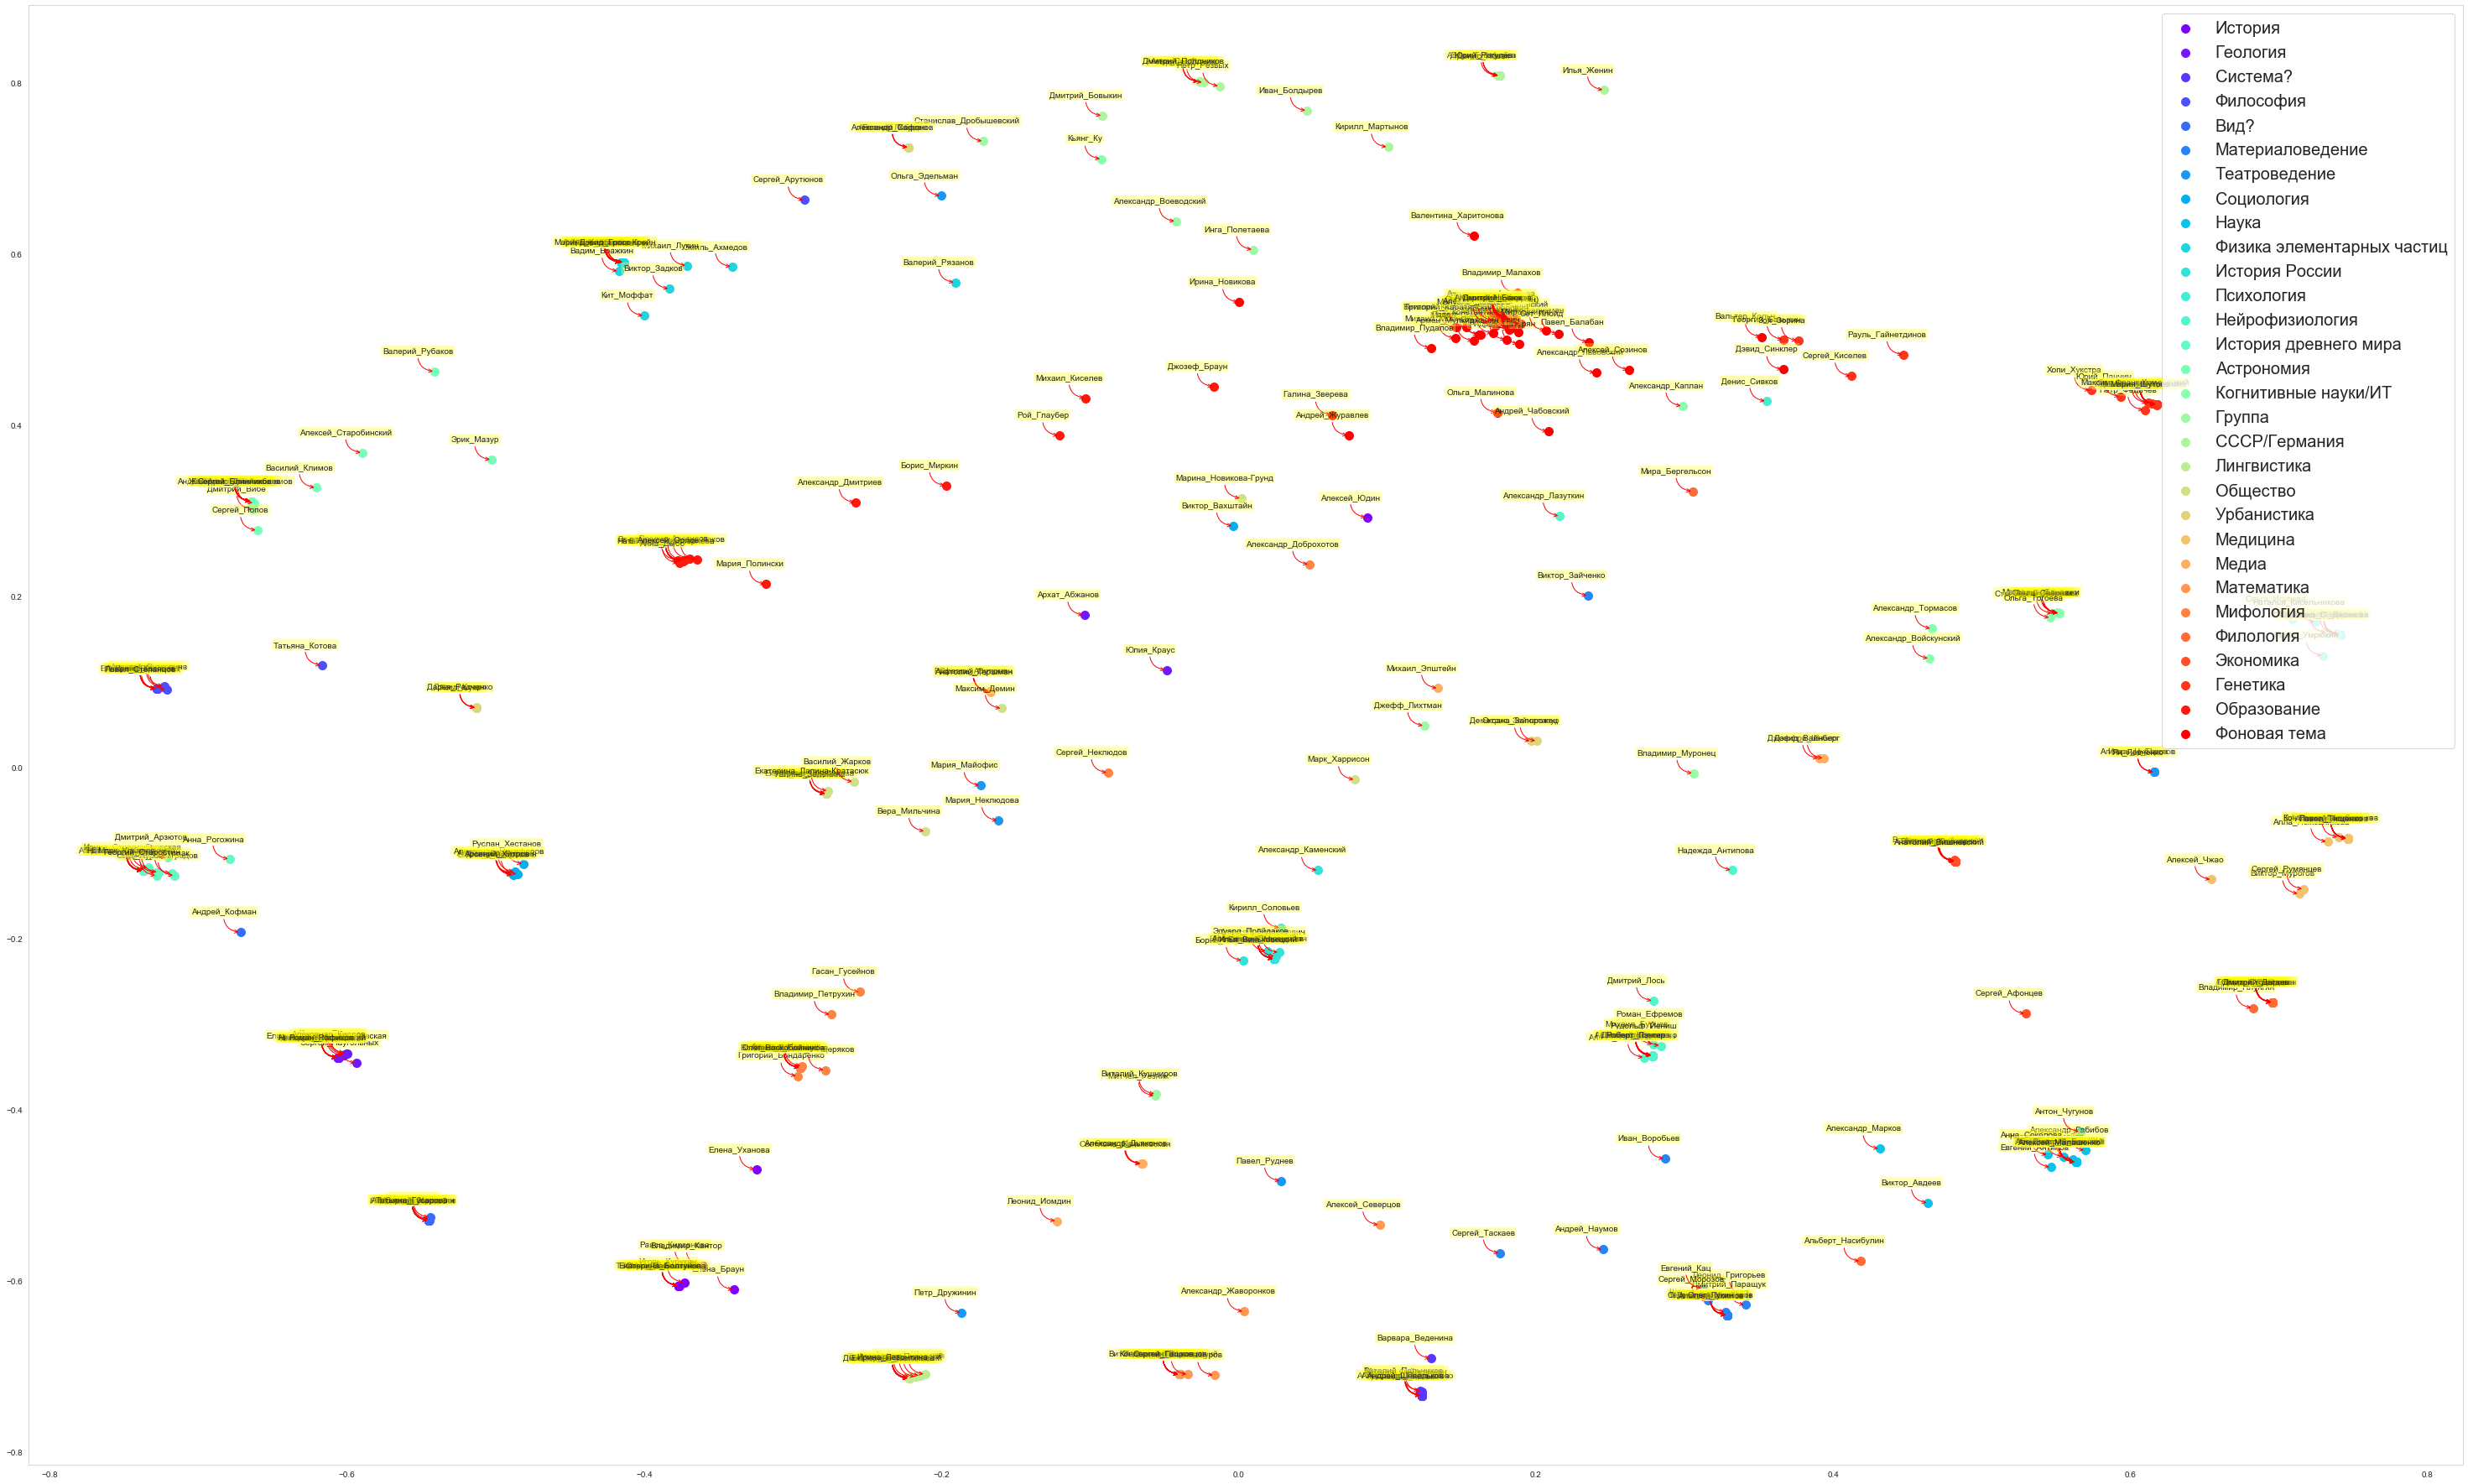

In [51]:
plt.figure(figsize=(52, 32))
for topic, color in zip(range(30), colors):
    authors = max_topics.index[max_topics[0]==topic]
    plt.scatter(MDS_transformed_cos[authors, 0],
                MDS_transformed_cos[authors, 1], 
                c=np.array([color]),
                s=100,
                label=topic_labels[topic]
           )
plt.legend(prop={'size': 20})
for author, xy in zip(p_ta.index, MDS_transformed_cos):
    plt.annotate(s=author[1], xy=xy, xytext=(-20,20), 
            textcoords='offset points', ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
                            color='red'))
# plt.savefig('tmp.pdf')
plt.show()

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [175]:
# Ваш код
p_dt = theta.div(theta.sum(axis=1), axis=0)
p_dt.index = topic_labels
navigator = pd.DataFrame()
for index, row in p_dt.iterrows():
    navigator = navigator.append(pd.Series(row.sort_values(ascending=False)[:10].index), ignore_index=True)
navigator.index = topic_labels

In [176]:
navigator

0  \
История                      http://postnauka.ru/video/3348   
Геология                    http://postnauka.ru/video/24245   
Система?                     http://postnauka.ru/video/3602   
Философия                   http://postnauka.ru/video/12524   
Вид?                        http://postnauka.ru/video/17913   
Материаловедение            http://postnauka.ru/video/41686   
Театроведение               http://postnauka.ru/video/39723   
Социология                  http://postnauka.ru/video/48335   
Наука                       http://postnauka.ru/video/19069   
Физика элементарных частиц  http://postnauka.ru/video/13043   
История России              http://postnauka.ru/video/35041   
Психология                  http://postnauka.ru/video/22892   
Нейрофизиология             http://postnauka.ru/video/16821   
История древнего мира       http://postnauka.ru/video/59201   
Астрономия                   http://postnauka.ru/video/6673   
Когнитивные науки/ИТ         http://postnauka.ru/video/7283   
Группа                      http://postnauka.ru/video/32898   
СССР/Германия               http://postnauka.ru/video/36581   
Лингвистика                 http://postnauka.ru/video/36272   
Общество                     http://postnauka.ru/video/9997   
Урбанистика                 http://postnauka.ru/video/12515   
Медицина                    http://postnauka.ru/video/54325   
Медиа                       http://postnauka.ru/video/32901   
Математика                  http://postnauka.ru/video/52738   
Мифология                    http://postnauka.ru/video/3387   
Филология                   http://postnauka.ru/video/10773   
Экономика                    http://postnauka.ru/video/3605   
Генетика                     http://postnauka.ru/video/5915   
Образование                  http://postnauka.ru/video/2973   
Фоновая тема                 http://postnauka.ru/video/5602   

                                                          1  \
История                      http://postnauka.ru/video/3406   
Геология                    http://postnauka.ru/video/15049   
Система?                    http://postnauka.ru/video/51382   
Философия                    http://postnauka.ru/video/7169   
Вид?                        http://postnauka.ru/video/38009   
Материаловедение            http://postnauka.ru/video/31182   
Театроведение               http://postnauka.ru/video/10759   
Социология                   http://postnauka.ru/video/3509   
Наука                       http://postnauka.ru/video/13700   
Физика элементарных частиц  http://postnauka.ru/video/22760   
История России              http://postnauka.ru/video/29992   
Психология                  http://postnauka.ru/video/22883   
Нейрофизиология             http://postnauka.ru/video/17416   
История древнего мира       http://postnauka.ru/video/53171   
Астрономия                  http://postnauka.ru/video/58574   
Когнитивные науки/ИТ        http://postnauka.ru/video/24182   
Группа                      http://postnauka.ru/video/31707   
СССР/Германия               http://postnauka.ru/video/12371   
Лингвистика                 http://postnauka.ru/video/56616   
Общество                    http://postnauka.ru/video/12083   
Урбанистика                 http://postnauka.ru/video/13742   
Медицина                     http://postnauka.ru/video/2541   
Медиа                       http://postnauka.ru/video/11246   
Математика                  http://postnauka.ru/video/42416   
Мифология                    http://postnauka.ru/video/9429   
Филология                    http://postnauka.ru/video/8964   
Экономика                   http://postnauka.ru/video/10380   
Генетика                    http://postnauka.ru/video/19436   
Образование                 http://postnauka.ru/video/31198   
Фоновая тема                http://postnauka.ru/video/51184   

                                                          2  \
История                      http://postnauka.ru/video/5464   
Геология                

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [54]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [55]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [233]:
# Ваш код
display(HTML(u"<h1>Навигатор по Постнауке</h1>"))
# for topic, refs in navigator.iterrows():
#     print(i)
#     for token in top_tokens_w.last_tokens[topic]:
#         print(token, end=' ')
for i in range(30):
    print('\nТема: ', topic_labels[i])
    print()
    print('Топ-10 слов: ')
    for token in top_tokens_w.last_tokens[model_artm.topic_names[i]]:
        print(token, end=' ')
    print('\nТоп-10 лекций по теме: ')
    for ref in navigator.iloc[i]:
        print(ref)
    print()


Тема:  История

Топ-10 слов: 
его власть александр писать историк имя великий римский знаменитый король церковь реформа средневековый над мысль 
Топ-10 лекций по теме: 
http://postnauka.ru/video/3348
http://postnauka.ru/video/3406
http://postnauka.ru/video/5464
http://postnauka.ru/video/24030
http://postnauka.ru/video/9968
http://postnauka.ru/video/24039
http://postnauka.ru/video/14292
http://postnauka.ru/video/31677
http://postnauka.ru/video/28942
http://postnauka.ru/video/23900


Тема:  Геология

Топ-10 слов: 
там раз планета земля интересный находиться температура тело открывать маленький обнаруживать образовываться вокруг вода атмосфера 
Топ-10 лекций по теме: 
http://postnauka.ru/video/24245
http://postnauka.ru/video/15049
http://postnauka.ru/video/9835
http://postnauka.ru/video/32889
http://postnauka.ru/video/13098
http://postnauka.ru/video/26206
http://postnauka.ru/video/25312
http://postnauka.ru/video/31695
http://postnauka.ru/video/49437
http://postnauka.ru/video/49261


Тема

политический право страна философия советский революция идея закон политика философский германия немецкий философ французский интерес 
Топ-10 лекций по теме: 
http://postnauka.ru/video/36581
http://postnauka.ru/video/12371
http://postnauka.ru/video/19574
http://postnauka.ru/video/31688
http://postnauka.ru/video/12738
http://postnauka.ru/video/42423
http://postnauka.ru/video/3418
http://postnauka.ru/video/13159
http://postnauka.ru/video/22087
http://postnauka.ru/video/2526


Тема:  Лингвистика

Топ-10 слов: 
например слово знать понимать текст значение вообще речь получаться посмотреть взять словарь скажем категория равный 
Топ-10 лекций по теме: 
http://postnauka.ru/video/36272
http://postnauka.ru/video/56616
http://postnauka.ru/video/48960
http://postnauka.ru/video/50793
http://postnauka.ru/video/1898
http://postnauka.ru/video/57524
http://postnauka.ru/video/46559
http://postnauka.ru/video/51499
http://postnauka.ru/video/56829
http://postnauka.ru/video/47548


Тема:  Общество

Топ-10 

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 